## Classifying news-wires a multiclass classification:
This problem is a instance of multiclass classification
because each data point should be classified into one category ,
the problem is more specifically an instance of single label multiclass
classification.

### Reuters dataset


In [1]:
from tensorflow.keras.datasets import reuters
(train_data,train_labels) , (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

print(len(train_data))
print(len(test_data))

2021-08-07 14:03:39.657036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-07 14:03:39.657060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mgrdich/.local/share/virtualenvs/deep_learning_python-pzRhtxR0/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mgrdich/.local/share/virtualenvs/deep_learning_python-pzRhtxR0/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters

8982
2246


### Decoding news-wires back to text



In [2]:
word_index = reuters.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}
decoded_newswire = ''.join([
    reverse_word_index.get(i-3,'?') for i in train_data[0]
])
print(decoded_newswire)

???saidasaresultofitsdecemberacquisitionofspacecoitexpectsearningspersharein1987of115to130dlrspershareupfrom70ctsin1986thecompanysaidpretaxnetshouldrisetonineto10mlndlrsfromsixmlndlrsin1986andrentaloperationrevenuesto19to22mlndlrsfrom125mlndlrsitsaidcashflowpersharethisyearshouldbe250tothreedlrsreuter3


the label associated with an example is an integer between `0-45` topic index

In [3]:
train_labels[0]
print(reverse_word_index[train_labels[0]])
# probably not decoded this way


to


In [4]:
# vectorized
from util.functions import vectorize_sequences
x_train = vectorize_sequences(train_data,10000)
x_test = vectorize_sequences(test_data,10000)

# OR categorical encoding
from tensorflow.keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


### Building your Network
But there is a new constraint here: the number of output classes has gone from 2 to 46. The
dimensionality of the output space is much larger.

In Stack of `Dense` Layers like you've been using each layer can only access information
present in the output the previous layer

In [5]:
from tensorflow.keras import models , layers
model = models.Sequential()
model.add(layers.Dense(64,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

2021-08-07 14:03:41.613191: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-07 14:03:41.658896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-07 14:03:41.659286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 950M computeCapability: 5.0
coreClock: 1.124GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 29.83GiB/s
2021-08-07 14:03:41.659404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-07 14:03:41.659460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

There are two things two know about this architecture
* You end the network with a dense layer of size 46. Each entry in this vec-
tor (each dimension) will encode a different output class.
* The last layer uses `softmax` activation , the network will output
`probability Distribution` over `46` different output classes
`output[i]` is the probability that the sample belongs to class `i`. The scores
`46` will sum to `1`.

`categorical_crossentropy` . It measures the distance between two probability distributions

In [6]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

### Validating you approach


In [7]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [8]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val,y_val)
)

2021-08-07 14:03:42.071749: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 319280000 exceeds 10% of free system memory.
2021-08-07 14:03:42.324585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-07 14:03:42.325073: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/20
16/16 [==============================] - 1s 29ms/step - loss: 2.6371 - accuracy: 0.5381 - val_loss: 1.7197 - val_accuracy: 0.6590
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.4051 - accuracy: 0.7127 - val_loss: 1.3008 - val_accuracy: 0.7210

### let's display the loss accuracy


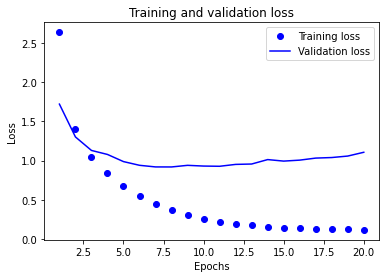

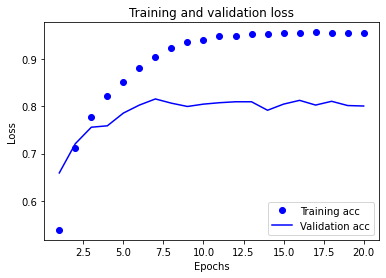

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf() # clears the figure


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### The network begins to overfit after nine epochs.
#### Let's train a new network from scratch for nine epochs and then evaluate it

In [10]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)


2021-08-07 14:03:49.197661: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 319280000 exceeds 10% of free system memory.


Epoch 1/9
16/16 [==============================] - 1s 23ms/step - loss: 2.7374 - accuracy: 0.4763 - val_loss: 1.8402 - val_accuracy: 0.6350
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.4738 - accuracy: 0.7067 - val_loss: 1.3371 - val_accuracy: 0.7080
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 1.0543 - accuracy: 0.7851 - val_loss: 1.1257 - val_accuracy: 0.7460

This approach reaches an accuracy of 80% approximately , with binary classification
problem the accuracy reached by a purely random classifier would be 50%
but in this case is closer to 19%

In [11]:
import copy
import numpy as np
test_labels_copy = copy.copy(test_labels)
print(np.random.shuffle(test_labels_copy))
#TODO ask this part
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(float(np.sum(hits_array)/len(test_labels)))

None
0.19367764915405164


## Getting prediction on the new data


In [12]:
predictions = model.predict(x_test)
print(predictions[0].shape)

# the coefficients in this vector is 1:
print(np.sum(predictions[0]))

# he largest entry is the predicted class—the class with the highest probability:

print(np.argmax(predictions[0]))

(46,)
1.0000001
3


### Different way of handling labels and loss ??

### The importance of having sufficiently large intermediate layers
the final outputs are 46-dimensional, you should
avoid intermediate layers with many fewer than 46 hidden units



In [13]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
            partial_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(x_val, y_val)
          )
results = model.evaluate(x_test, one_hot_test_labels)

print(results)

2021-08-07 14:03:52.956492: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 319280000 exceeds 10% of free system memory.


Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7531 - accuracy: 0.6297 - val_loss: 1.2068 - val_accuracy: 0.7220
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9343 - accuracy: 0.7935 - val_loss: 0.9739 - val_accuracy: 0.7970

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these eight-dimensional representations, but not all of it.

## Prediction house prices : a regression example
This consists of predicting a **continuous**
value instead of a discrete label: for instance, predicting the temperature tomorrow,
given meteorological data; or predicting the time that a software project will take to
complete, given its specifications.

In [14]:
from tensorflow.keras.datasets import boston_housing
(btrain_data,btrain_targets),(btest_data, btest_targets) = boston_housing.load_data()
print(btrain_data.shape)
print(btest_data.shape)

# The targets are the median values of owner-occupied homes, in thousands of dollars:
print(btrain_targets)

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

It would be problematic to feed into a neural network values that all take wildly differ-ent ranges
A practice **normalization** for each feature in the input data (column in the input data matrix)
You divide by the mean of the feature than divide by the standard deviation
So it is centered around 0 and has a unit standard deviation

In [15]:
b_mean = btrain_data.mean(axis=0)
btrain_data -= b_mean
b_std = btrain_data.std(axis=0)

btrain_data /= b_std

btest_data -= b_mean
btest_data /= b_std

**normalizing the test data are computed using the training data no any result
from the test data should be computed**

## Building your Network

In [16]:
def build_model():
    # mse -> mean squared method
    my_model = models.Sequential()
    my_model.add(layers.Dense(64,activation='relu',input_shape=(btrain_data.shape[1],)))
    my_model.add(layers.Dense(64,activation='relu'))
    my_model.add(layers.Dense(1))
    my_model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return my_model


## Validation with K-fold approach
since we have few data validation set is very small
SO
validation score might change depending on which data you choose the validation
scores might have a high variance with regard to the validation split. This would pre-
vent you from reliably evaluating your model.

### K-fold cross validation
* split data into `K` partitions typically (`K = 4` or `K = 5`)
* instantiating `K` identical models
* training each one on K – 1 partitions while evaluating on the remaining partition

In [17]:
import util.functions as fn

obj = fn.kfold_validation(
     k=4,
     num_epochs=100,
     train_data=btrain_data,
     train_targets=btrain_targets,
     build_fn=build_model
 )
print(obj)
print(len(obj))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
[{'history': <tensorflow.python.keras.callbacks.History object at 0x7effb00bf5b0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7effed003ca0>, 'evaluate': [5.86143159866333, 1.8309224843978882]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff703451f0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff8c033790>, 'evaluate': [10.28377628326416, 2.3416907787323]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff701f52e0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff8c065f70>, 'evaluate': [17.804061889648438, 2.764087438583374]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7effb01570a0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff70151b80>, 'evaluate': [13.241730690002441, 2.5487253665924072]}]
4


In [18]:
scores  = []
# getting all the scores
for i in obj:
    # print(i)
    val_mse , val_mae = i['evaluate']
    scores.append(val_mae)

np.mean(scores)

2.3713565170764923

In [29]:
obj = fn.kfold_validation(
     k=4,
     num_epochs=500,
     train_data=btrain_data,
     train_targets=btrain_targets,
     build_fn=build_model,
     validation=True
 )
print(obj)
print(len(obj))


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
[{'history': <tensorflow.python.keras.callbacks.History object at 0x7eff6a852f40>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff69f3abb0>}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff69c3c220>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff69e29c70>}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff69cf6a90>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff69c57be0>}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff6920a1c0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff69c78d90>}]
4


In [36]:
scores2 = []
for i in obj:
    scores2.append(i['history'].history['val_mae'])

print(scores2)

average_mae_history = [np.mean([x[i] for x in scores2]) for i in range(500)]

print(average_mae_history)

[[4.293904781341553, 3.5620412826538086, 2.825232744216919, 2.5087950229644775, 2.568340301513672, 2.390486478805542, 2.656550407409668, 2.228912830352783, 2.206637144088745, 2.5727033615112305, 2.364309549331665, 2.331333637237549, 2.1959357261657715, 2.097020387649536, 2.050922393798828, 2.0931668281555176, 2.0709195137023926, 1.998624324798584, 2.107146978378296, 2.208810567855835, 1.9581243991851807, 2.270348310470581, 2.1862332820892334, 2.1487784385681152, 2.054692268371582, 2.063251495361328, 2.0386321544647217, 2.01470947265625, 2.0197865962982178, 2.0136568546295166, 2.1009089946746826, 2.004210948944092, 1.9723371267318726, 2.377991199493408, 1.9068931341171265, 2.087489366531372, 2.2265429496765137, 2.124685764312744, 2.170149803161621, 2.041146993637085, 2.4320876598358154, 2.087857723236084, 1.9576711654663086, 1.9305156469345093, 1.820319414138794, 2.11519455909729, 1.9313533306121826, 2.108499050140381, 1.859194278717041, 1.9002504348754883, 2.001121759414673, 2.00279402

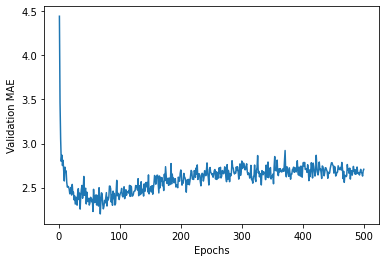

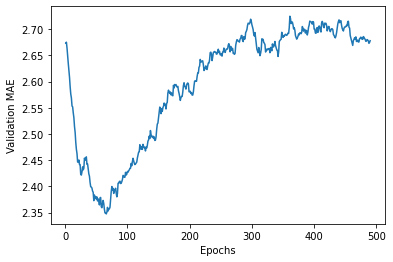

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history) + 1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


# lets make it smoother # Todo check me later and transform into file
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [44]:
obj = fn.kfold_validation(
     k=4,
     num_epochs=80,
     train_data=btrain_data,
     train_targets=btrain_targets,
     build_fn=build_model
 )
print(obj)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
[{'history': <tensorflow.python.keras.callbacks.History object at 0x7eff3a7df0d0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff69d0e310>, 'evaluate': [7.7820587158203125, 1.879712700843811]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff3a6ba130>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff3a6e1130>, 'evaluate': [10.861577987670898, 2.333094596862793]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff3a5721f0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff3a59c8e0>, 'evaluate': [13.563711166381836, 2.4666569232940674]}, {'history': <tensorflow.python.keras.callbacks.History object at 0x7eff3a42d3a0>, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7eff3a456160>, 'evaluate': [12.734179496765137, 2.652944326400757]}]


In [43]:
scores  = []
# getting all the scores
for i in obj:
    # print(i)
    val_mse , val_mae = i['evaluate']
    scores.append(val_mae)

np.mean(scores)


2.5329996943473816